In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import resize

import keras
from keras import models, layers, optimizers
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [4]:
def preprocess(x):
    x_resized= resize(x,(x.shape[0],32,32),anti_aliasing=True)
    x_resized = (x_resized.astype('float') - 127.5)/127.5
    x_resized = x_resized.reshape(60000,32,32,1)
    return x_resized

def load_data(p=True):
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    if p:
        x_train = preprocess(x_train)
        return (x_train,y_train,x_test,y_test)
    else:
        return (x_train,y_train,x_test,y_test)  

In [5]:
(X_train,y_train,x_test,y_test) = load_data()
print(X_train.shape)

(60000, 32, 32, 1)


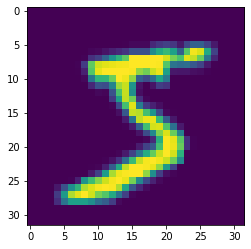

In [6]:
plt.imshow(X_train[0,:,:,0])

In [7]:
def check_gen(g):
    noise= np.random.normal(0,1,[100,100])
    gi = g.predict(noise)
    gi = gi.reshape(100,32,32)
    plt.figure(figsize=(5,5))
    plt.imshow(gi[99,:,:])

In [8]:
def create_gen():
    model = models.Sequential()
    model.add(layers.Dense(4*4*1024,use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Reshape((4,4,1024)))
    assert model.output_shape == (None,4,4,1024)
    
    model.add(layers.Conv2DTranspose(512, (5,5), strides=(1,1), padding='same'))
    assert model.output_shape == (None,4,4,512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same'))
    assert model.output_shape == (None,8,8,256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))
    assert model.output_shape == (None,8,8,128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides= (2,2), padding='same'))
    assert model.output_shape == (None,16,16,64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides= (2,2), padding='same', activation = 'tanh'))
    assert model.output_shape == (None,32,32,1)
    
    model.compile(loss='binary_crossentropy',optimizer='adam')
    
    return model

def create_disc():
    model = models.Sequential()
    
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,1]))
    assert model.output_shape == (None,16,16,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    assert model.output_shape == (None,8,8,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (5,5), strides=(1,1), padding='same'))
    assert model.output_shape == (None,8,8,256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
    assert model.output_shape == (None,4,4,512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(1024, (5,5), strides=(1,1), padding='same'))
    assert model.output_shape == (None,4,4,1024)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam')
    
    return model

def create_gan(discriminator,generator):
    discriminator.trainable=False
    
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = models.Model(inputs=gan_input,outputs=gan_output)
    
    gan.compile(loss='binary_crossentropy',optimizer='adam')
    
    return gan

In [9]:
g = create_gen()
d = create_disc()

In [10]:
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 512)         13107712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 4, 4, 512)        

In [11]:
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)        

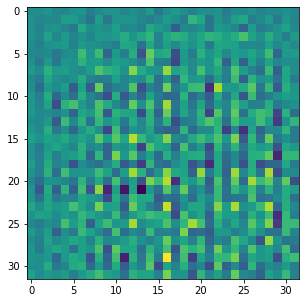

In [12]:
check_gen(g)

In [13]:
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 1)         19118337  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 17435905  
Total params: 36,554,242
Trainable params: 19,083,649
Non-trainable params: 17,470,593
_________________________________________________________________


In [14]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,32,32)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('dcgan_generated_image %d.png' %epoch)

In [15]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] //batch_size
    
    # Creating GAN
    generator= create_gen()
    discriminator= create_disc()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_count)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 1


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 2


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 3


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 4


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 5


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 6


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 7


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 8


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 9


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 10


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 11


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 12


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 13


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 14


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 15


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 16


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 17


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 18


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 19


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 20


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 21


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 22


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 23


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 24


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 25


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 26


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 27


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 28


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 29


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 30


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 31


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 32


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 33


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 34


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 35


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 36


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 37


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 38


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 39


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 40


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 41


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 42


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

Epoch 43


 59%|███████████████████████████████████████████████▎                                | 277/468 [01:42<01:09,  2.76it/s]

KeyboardInterrupt: 

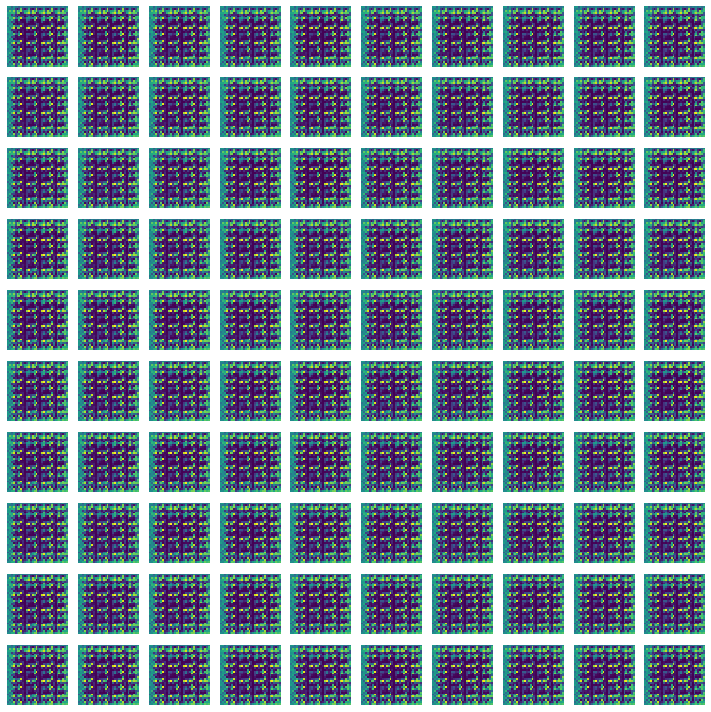

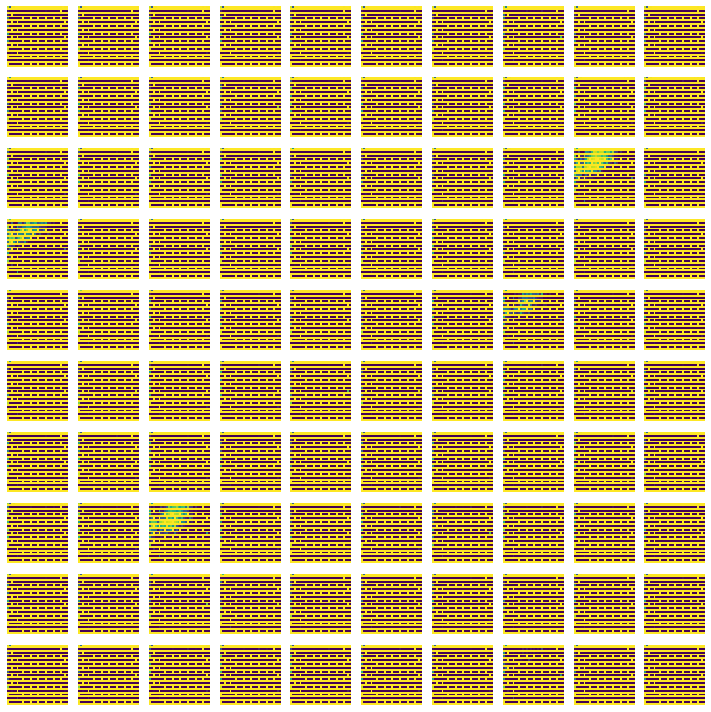

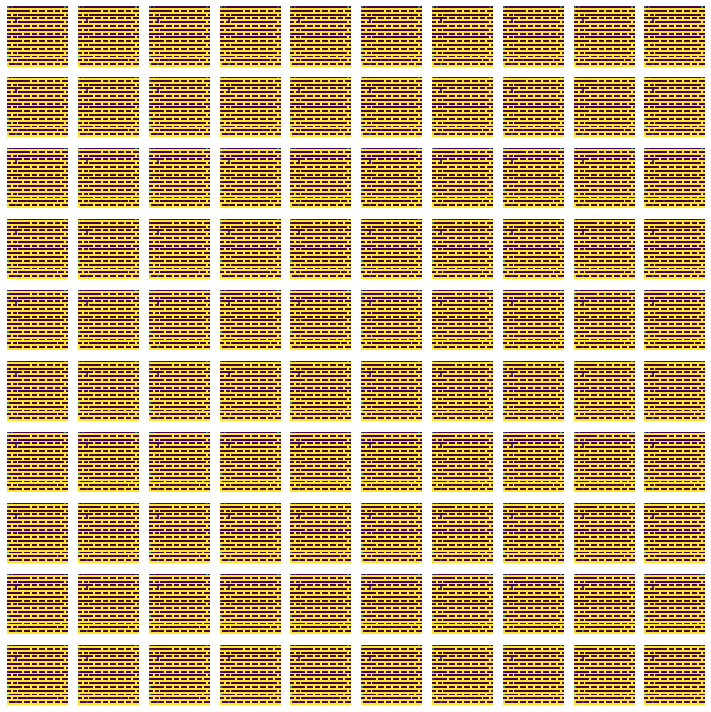

In [16]:
training(60,128)